In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/seahkahyen/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.BruteForceEstimator as bfEstimator
import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils

from src.visualization import SamplingMethod, BFmethod
from src.data_processing.SampleEstimator import SampleEstimator
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

cpu


/home/seahkahyen/VecRepV3/data/triangles-unique/weights/


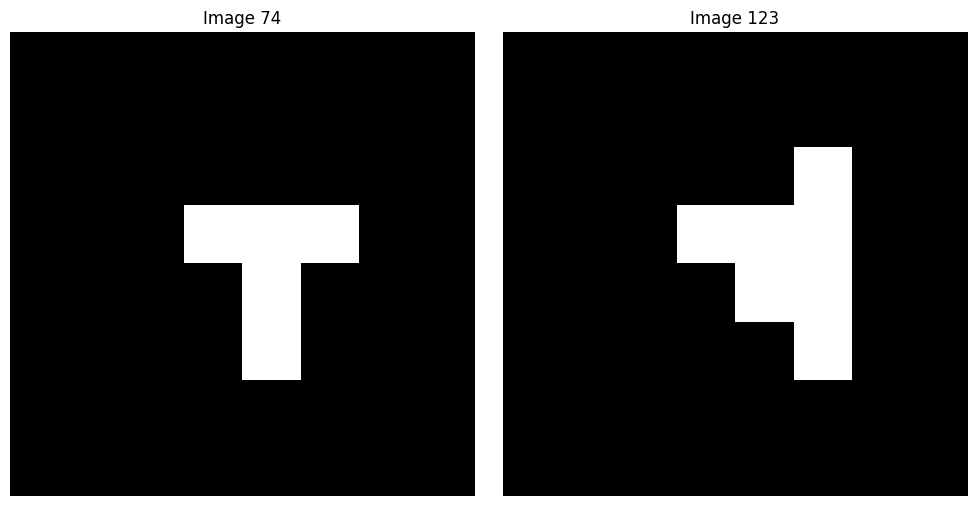

In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 32

imageType = "triangles" #6x6 triangle in 12x12 matrix shapes_3_dims_6_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k=5

bruteForceEstimator = bfEstimator.BruteForceEstimator(
    imageType=imageType, filters=filters, imageProductType=imageProductType, embeddingType=embeddingType, overwrite=overwrite)

print(bruteForceEstimator.weightingFilepath)
index1 = np.random.randint(len(bruteForceEstimator.imageSet))
index2 = np.random.randint(len(bruteForceEstimator.imageSet))

input1=bruteForceEstimator.imageSet[index1]
input2=bruteForceEstimator.imageSet[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in bruteForceEstimator.imageSet:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]

In [4]:
model = models.SimpleCNN(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                               f"best_model_batch_greyscale_8bin_LPS_circular_{dimensions}d.pt"),
                                                map_location=torch.device('cpu')))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgpool): AdaptiveAv

In [5]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset[index2])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

matrixA = bruteForceEstimator.matrixA
matrixG = bruteForceEstimator.matrixG
dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("Difference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  0.35224688053131104
Dot product value of model:  0.3208673298358917
Loss:  0.03137955069541931

Dot product value of BF Method:  0.3809188061719914
Loss:  0.02867192029953003
Difference in values of BF Method and Model Method:  0.06005147099494934


----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 74: K-Score = 0.8571428571428571
Intersection sets : [ 18  60  74 124 167 178]
Union sets: [ 18  60  61  74 124 167 178]

Top 7 values of Vector b
Rank 1: Value = 1.0, Index = 74
Rank 2: Value = 0.8257417678833008, Index = 124
Rank 3: Value = 0.8257417678833008, Index = 167
Rank 4: Value = 0.8257417678833008, Index = 178
Rank 5: Value = 0.7888543605804443, Index = 18
Rank 6: Value = 0.7888543605804443, Index = 60
Rank 7: Value = 0.7888543605804443, Index = 61

Top 7 values of Vector c
Rank 1: Value = 1.0, Index = 74
Rank 2: Value = 0.839017082827434, Index = 124
Rank 3: Value = 0.8390170779437028, Index = 178
Rank 4: Value = 0.781064841384984, Index = 167
Rank 5: Value = 0.7020745742777356, Index = 18
Rank 6: Value = 0.6960728152112464, Index = 60
Rank 7: Value = 0.6960728093525842, Index = 61

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Do

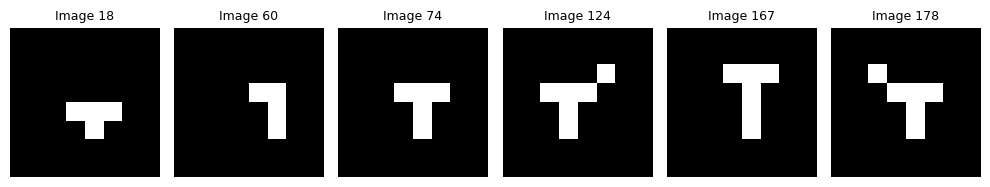


Plotting images in the union set:


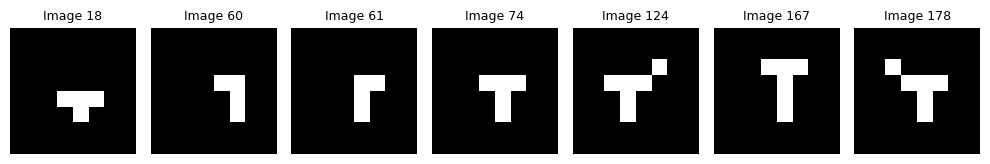


For translationally unique plots: 
Image 18 has no translationally similar images.
Image 60 has no translationally similar images.
Image 61 has no translationally similar images.
Image 74 has no translationally similar images.
Image 124 has no translationally similar images.
Image 167 has no translationally similar images.
Image 178 has no translationally similar images.

Plotting images in the intersection set:


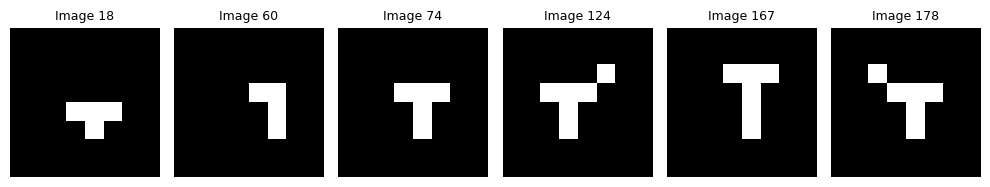


Plotting images in the union set:


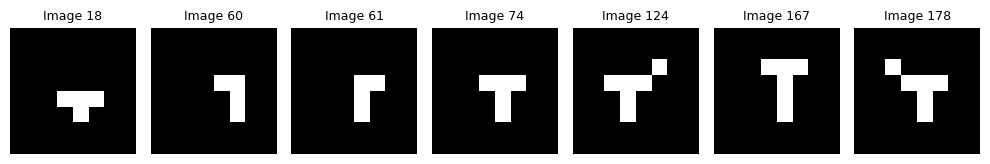

Estimating K-Score for Image 123: K-Score = 0.45454545454545453
Intersection sets : [ 75 116 123 127 168]
Union sets: [ 75  90  91 116 123 125 127 168 179 187 190]

Top 11 values of Vector b
Rank 1: Value = 1.0, Index = 123
Rank 2: Value = 0.8708287477493286, Index = 127
Rank 3: Value = 0.8516402244567871, Index = 75
Rank 4: Value = 0.7142858505249023, Index = 90
Rank 5: Value = 0.7142858505249023, Index = 91
Rank 6: Value = 0.7142858505249023, Index = 116
Rank 7: Value = 0.7142858505249023, Index = 125
Rank 8: Value = 0.7142858505249023, Index = 168
Rank 9: Value = 0.7142858505249023, Index = 179
Rank 10: Value = 0.7142858505249023, Index = 187
Rank 11: Value = 0.6903085708618164, Index = 45

Top 11 values of Vector c
Rank 1: Value = 1.0, Index = 123
Rank 2: Value = 0.8717922545182978, Index = 127
Rank 3: Value = 0.8136667863513599, Index = 75
Rank 4: Value = 0.7375747525534833, Index = 190
Rank 5: Value = 0.7267504370510527, Index = 168
Rank 6: Value = 0.713218048803595, Index = 116


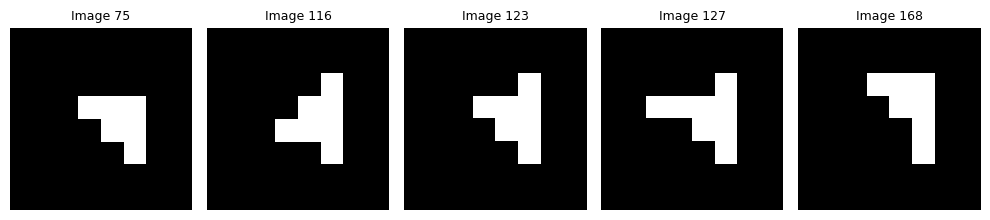


Plotting images in the union set:


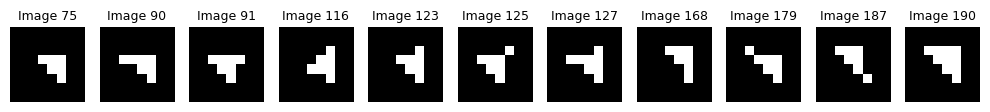


For translationally unique plots: 
Image 75 has no translationally similar images.
Image 90 has no translationally similar images.
Image 91 has no translationally similar images.
Image 116 has no translationally similar images.
Image 123 has no translationally similar images.
Image 125 has no translationally similar images.
Image 127 has no translationally similar images.
Image 168 has no translationally similar images.
Image 179 has no translationally similar images.
Image 187 has no translationally similar images.
Image 190 has no translationally similar images.

Plotting images in the intersection set:


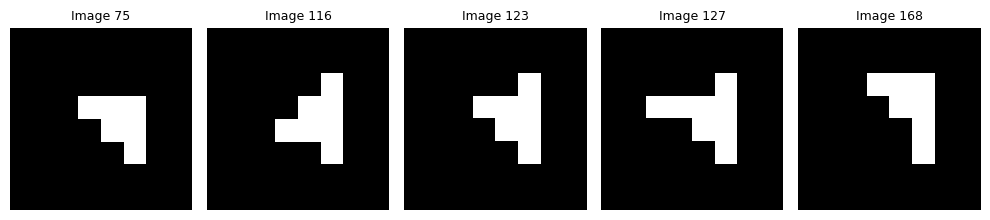


Plotting images in the union set:


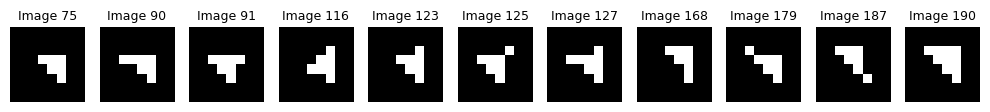

----------------
Model Method -- KNN-IOU score
----------------
Estimating K-Score for Image 74: K-Score = 0.8571428571428571
Intersection sets : [ 60  61  74 124 167 178]
Union sets: [ 18  60  61  74 124 167 178]

Top 7 values of Vector b
Rank 1: Value = 1.0, Index = 74
Rank 2: Value = 0.8257417678833008, Index = 124
Rank 3: Value = 0.8257417678833008, Index = 167
Rank 4: Value = 0.8257417678833008, Index = 178
Rank 5: Value = 0.7888543605804443, Index = 18
Rank 6: Value = 0.7888543605804443, Index = 60
Rank 7: Value = 0.7888543605804443, Index = 61

Top 7 values of Vector c
Rank 1: Value = 1.0, Index = 74
Rank 2: Value = 0.8577582836151123, Index = 167
Rank 3: Value = 0.8156443238258362, Index = 61
Rank 4: Value = 0.7893480062484741, Index = 124
Rank 5: Value = 0.786037266254425, Index = 178
Rank 6: Value = 0.7813196778297424, Index = 60
Rank 7: Value = 0.726553738117218, Index = 18

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot prod

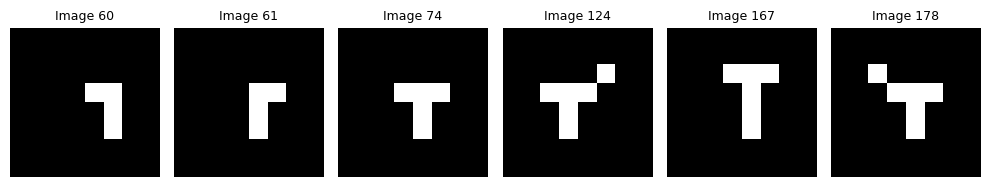


Plotting images in the union set:


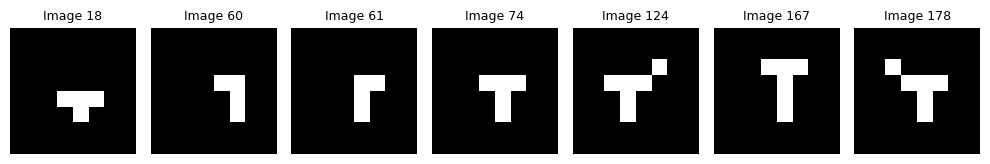


For translationally unique plots: 
Image 18 has no translationally similar images.
Image 60 has no translationally similar images.
Image 61 has no translationally similar images.
Image 74 has no translationally similar images.
Image 124 has no translationally similar images.
Image 167 has no translationally similar images.
Image 178 has no translationally similar images.

Plotting images in the intersection set:


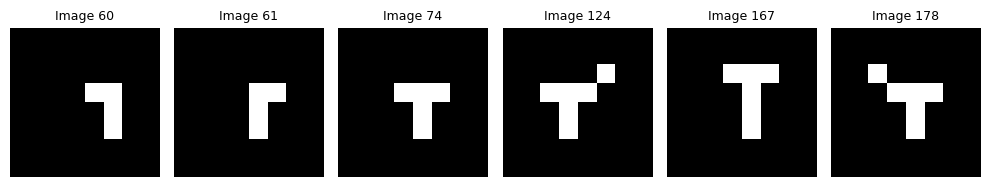


Plotting images in the union set:


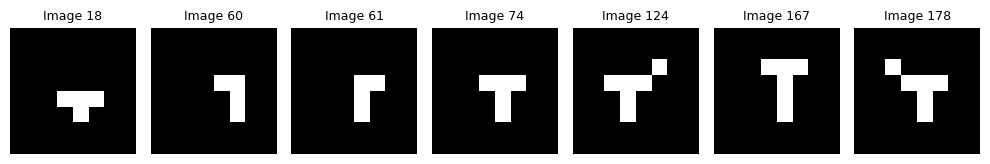

Estimating K-Score for Image 123: K-Score = 0.6
Intersection sets : [ 75  90 123 127 168 187]
Union sets: [ 75  90  91 116 123 125 127 168 179 187]

Top 10 values of Vector b
Rank 1: Value = 1.0, Index = 123
Rank 2: Value = 0.8708287477493286, Index = 127
Rank 3: Value = 0.8516402244567871, Index = 75
Rank 4: Value = 0.7142858505249023, Index = 90
Rank 5: Value = 0.7142858505249023, Index = 91
Rank 6: Value = 0.7142858505249023, Index = 116
Rank 7: Value = 0.7142858505249023, Index = 125
Rank 8: Value = 0.7142858505249023, Index = 168
Rank 9: Value = 0.7142858505249023, Index = 179
Rank 10: Value = 0.7142858505249023, Index = 187

Top 10 values of Vector c
Rank 1: Value = 1.0000001192092896, Index = 123
Rank 2: Value = 0.9246544241905212, Index = 127
Rank 3: Value = 0.8664854168891907, Index = 75
Rank 4: Value = 0.8629041910171509, Index = 168
Rank 5: Value = 0.7815185189247131, Index = 90
Rank 6: Value = 0.7785876989364624, Index = 187
Rank 7: Value = 0.7723698616027832, Index = 179
R

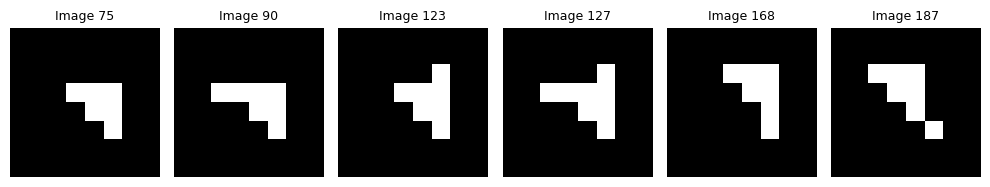


Plotting images in the union set:


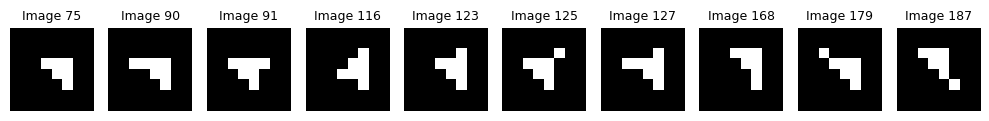


For translationally unique plots: 
Image 75 has no translationally similar images.
Image 90 has no translationally similar images.
Image 91 has no translationally similar images.
Image 116 has no translationally similar images.
Image 123 has no translationally similar images.
Image 125 has no translationally similar images.
Image 127 has no translationally similar images.
Image 168 has no translationally similar images.
Image 179 has no translationally similar images.
Image 187 has no translationally similar images.

Plotting images in the intersection set:


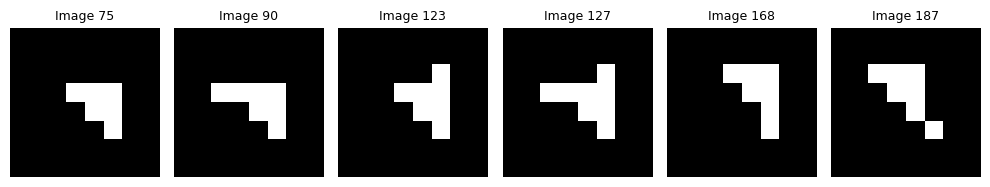


Plotting images in the union set:


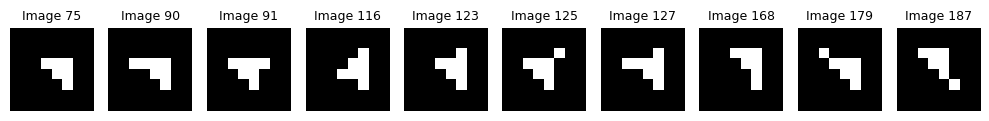

In [6]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = bruteForceEstimator.matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, bruteForceEstimator.matrixA)
imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, bruteForceEstimator.imageSet)

vectorb_bf2 = bruteForceEstimator.matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, bruteForceEstimator.matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, bruteForceEstimator.imageSet)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = bruteForceEstimator.matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, bruteForceEstimator.imageSet)

vectorb_model2 = bruteForceEstimator.matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, bruteForceEstimator.imageSet)


NCC Interval		Average Loss
-0.1-0.0		0.1588 (1583 samples)
-0.2--0.1		0.2140 (5146 samples)
-0.3--0.2		0.2182 (294 samples)
-0.4--0.3		0.7603 (336 samples)
-0.5--0.4		0.6072 (800 samples)
-0.6--0.5		0.0000 (0 samples)
-0.7--0.6		0.0000 (0 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.1821 (8109 samples)
0.1-0.2		0.1724 (5087 samples)
0.2-0.3		0.1321 (4653 samples)
0.3-0.4		0.1424 (5408 samples)
0.4-0.5		0.1392 (1277 samples)
0.5-0.6		0.1495 (1984 samples)
0.6-0.7		0.1385 (1107 samples)
0.7-0.8		0.0869 (728 samples)
0.8-0.9		0.0419 (160 samples)
0.9-1.0		0.0000 (192 samples)


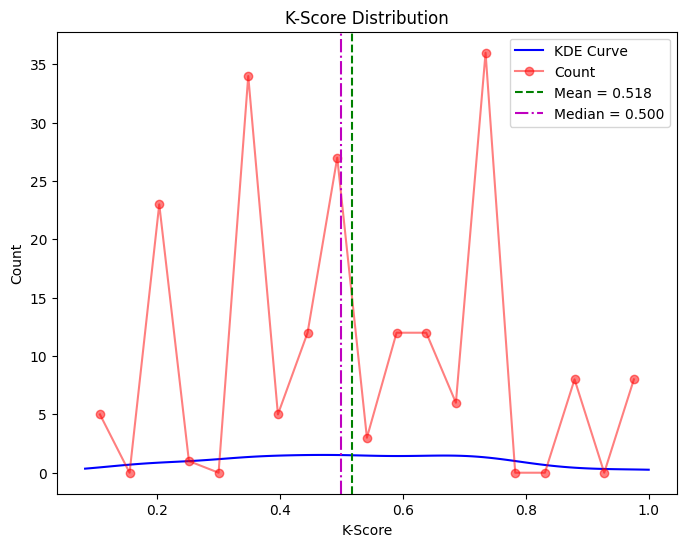

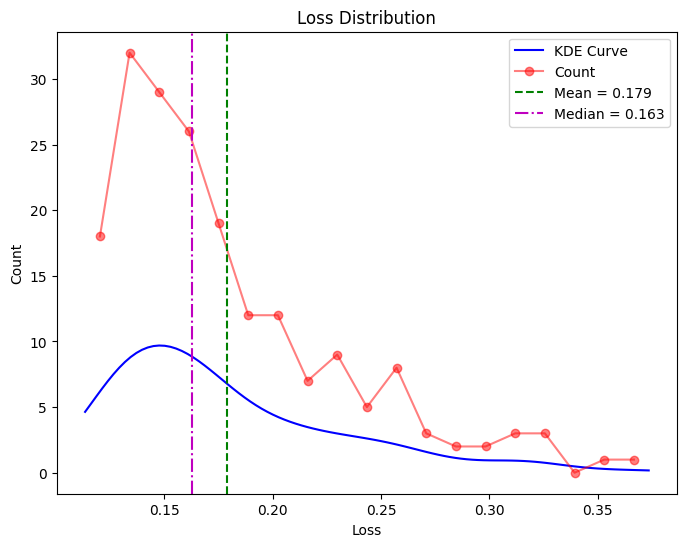

In [7]:
#--------------------Visualisation across dataset-------------------
#input(array_dataset, tensor_dataset)
kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation(bruteForceEstimator.imageSet, input_dataset, model, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score")
imgplt.plot_score_distribution(losses, "Loss")

Dimension 16
K-Score for index 0 is 0.6
Average loss for index 0 is 0.19340140910935588
K-Score for index 1 is 0.3333333333333333
Average loss for index 1 is 0.19016917733824812
K-Score for index 2 is 0.7142857142857143
Average loss for index 2 is 0.14105466335119368
K-Score for index 3 is 0.09090909090909091
Average loss for index 3 is 0.27029383393043344
K-Score for index 4 is 0.3333333333333333
Average loss for index 4 is 0.19195104720226178
K-Score for index 5 is 0.35294117647058826
Average loss for index 5 is 0.20400227964273654
K-Score for index 6 is 0.6
Average loss for index 6 is 0.1865712059661746
K-Score for index 7 is 1.0
Average loss for index 7 is 0.11107493006663087
K-Score for index 8 is 0.3333333333333333
Average loss for index 8 is 0.15699630590582578
K-Score for index 9 is 0.6
Average loss for index 9 is 0.1510785806652469
K-Score for index 10 is 0.45454545454545453
Average loss for index 10 is 0.19457504017433772
K-Score for index 11 is 0.2
Average loss for index 11 

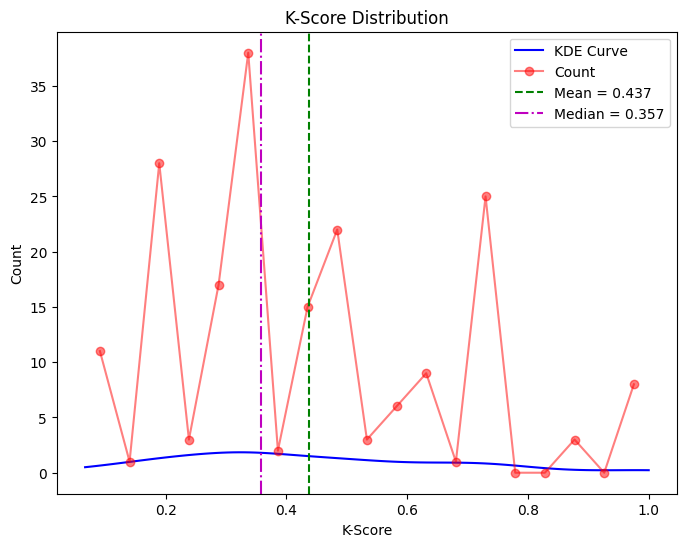

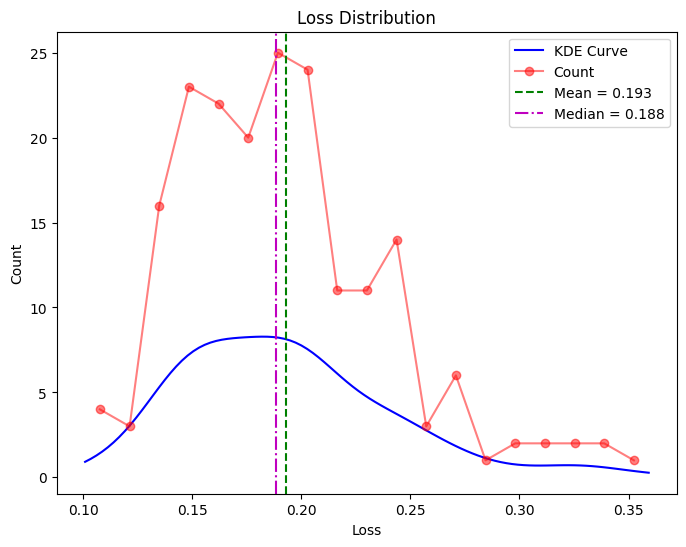

Dimension 32
K-Score for index 0 is 0.6
Average loss for index 0 is 0.1831906539737247
K-Score for index 1 is 0.3333333333333333
Average loss for index 1 is 0.2564628427887025
K-Score for index 2 is 0.7142857142857143
Average loss for index 2 is 0.1619371777002622
K-Score for index 3 is 0.2
Average loss for index 3 is 0.27052383703024435
K-Score for index 4 is 0.5
Average loss for index 4 is 0.2234636953411003
K-Score for index 5 is 0.35294117647058826
Average loss for index 5 is 0.158026079821866
K-Score for index 6 is 0.6
Average loss for index 6 is 0.1905195943933601
K-Score for index 7 is 0.7142857142857143
Average loss for index 7 is 0.15863163359851265
K-Score for index 8 is 0.3333333333333333
Average loss for index 8 is 0.14935708149763136
K-Score for index 9 is 0.6
Average loss for index 9 is 0.22184727327354872
K-Score for index 10 is 0.6
Average loss for index 10 is 0.203817588412979
K-Score for index 11 is 0.5
Average loss for index 11 is 0.23324934536746392
K-Score for inde

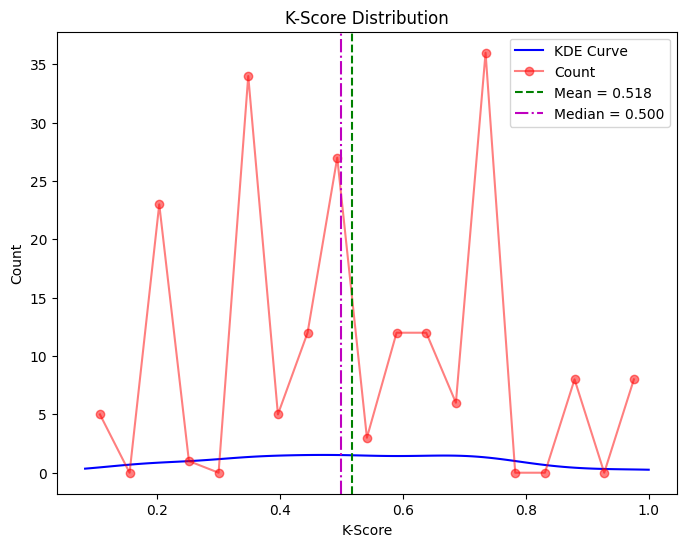

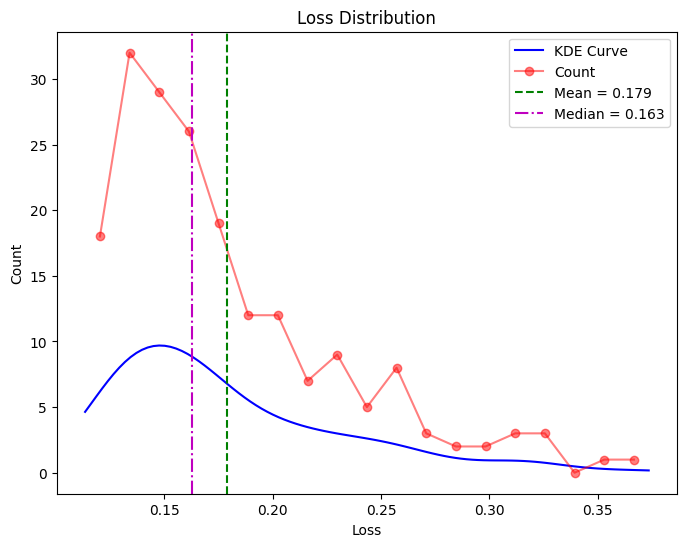

Dimension 48
K-Score for index 0 is 0.6
Average loss for index 0 is 0.18235314381308854
K-Score for index 1 is 0.7142857142857143
Average loss for index 1 is 0.21987274793597558
K-Score for index 2 is 0.7142857142857143
Average loss for index 2 is 0.1434640681836754
K-Score for index 3 is 0.2
Average loss for index 3 is 0.2580435934263126
K-Score for index 4 is 0.7142857142857143
Average loss for index 4 is 0.18539093791817626
K-Score for index 5 is 0.35294117647058826
Average loss for index 5 is 0.15537256056753299
K-Score for index 6 is 0.6
Average loss for index 6 is 0.18632561554356167
K-Score for index 7 is 0.7142857142857143
Average loss for index 7 is 0.15829775901511312
K-Score for index 8 is 0.3333333333333333
Average loss for index 8 is 0.12948390162394693
K-Score for index 9 is 0.6
Average loss for index 9 is 0.15859249894856475
K-Score for index 10 is 0.6
Average loss for index 10 is 0.1668956409363697
K-Score for index 11 is 0.7142857142857143
Average loss for index 11 is 

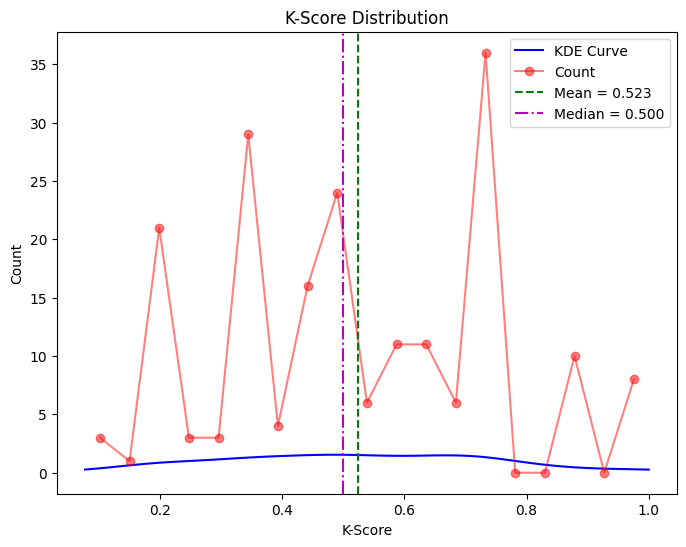

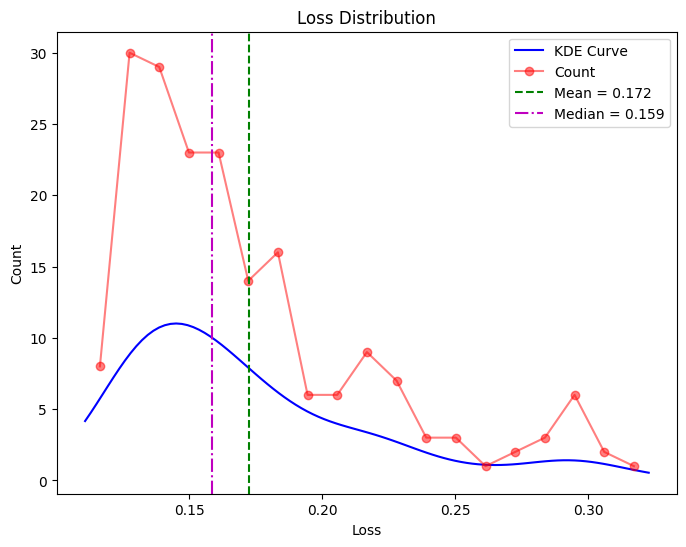

In [14]:
#--------------------Visualisation across dataset across dimensions-------------------
dimensions = [16, 32, 48]
for dim in dimensions:
    print(f"Dimension {dim}")
    embeddingType = f"pencorr_{dim}"
    bruteForceEstimator = bfEstimator.BruteForceEstimator(
        imageType=imageType, filters=filters, imageProductType=imageProductType, embeddingType=embeddingType, overwrite=overwrite)
    
    input_dataset = []
    for img in bruteForceEstimator.imageSet:
        img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
        input_dataset.append(img_tensor)
    input_dataset = [tensor.float() for tensor in input_dataset] 
    stacked_tensor = torch.stack(input_dataset)
    input_dataset = stacked_tensor.cpu().numpy()      
    input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
    num = len(input_dataset)
    
    model = models.SimpleCNN(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                                   f"best_model_batch_greyscale_8bin_LPS_circular_{dim}d.pt"),
                                                    map_location=torch.device('cpu')))
    model.eval()


    kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation(bruteForceEstimator.imageSet, input_dataset, model, k)
    
    imgcalc.loss_per_ncc_score(ncc_loss_dict)
    imgplt.plot_score_distribution(kscores, "K-Score")
    imgplt.plot_score_distribution(losses, "Loss")

In [8]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
matrixG = bruteForceEstimator.matrixG
matrixA = bruteForceEstimator.matrixA
dot_product_matrix = np.dot(matrixA.T, matrixA)

mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Pencorr (A'A) and NCC (G):", mean_squared_difference)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Model: {mean_squared_difference}")

Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.006420590184493713

Mean Squared Difference of Model and NCC (G): 0.0545934850522713
Mean Squared Difference of Model and Pencorr (A'A): 0.04514970256608799

Printing matrices

Matrix G: [[1.         0.33333337 0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.33333337 1.         0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.7320509  0.7320509  1.         ... 0.06066024 0.26491106 0.26491106]
 ...
 [0.22474492 0.22474492 0.06066024 ... 1.         0.34164071 0.56524754]
 [0.09544504 0.09544504 0.26491106 ... 0.34164071 1.         0.39999998]
 [0.09544504 0.09544504 0.26491106 ... 0.56524754 0.39999998 1.        ]]

Matrix A'A (Pencorr): [[1.         0.27011734 0.64123765 ... 0.16394834 0.09979368 0.10041566]
 [0.27011734 1.         0.5495619  ... 0.19023422 0.05495748 0.17736492]
 [0.64123765 0.5495619  1.         ... 0.128817   0.19480639 0.11914658]
 ...
 [0.16394834 0.19023422 0.128817   ... 1.         0.37891402 0.646

In [22]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
     

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Transformed Model: {mean_squared_difference}")

# magnitude = np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
# print("magnitude: ", magnitude)
# vector = model_transformed[index1].detach().cpu().numpy()/magnitude
# print("vector after normalisation: ", vector)

# mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], vector)
# print(f"Mean Squared Difference of Pencorr (A) and Normalised TransformedModel: {mean_squared_difference}")
# magnitude = np.linalg.norm(vector)
# print("magnitude: ", magnitude)

Difference between matrices

Mean Squared Difference of Model and NCC (G): 0.11275908822053353
Mean Squared Difference of Model and Pencorr (A'A): 0.10629051917384562

Printing matrices after transformation

Matrix G: [[1.         0.33333337 0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.33333337 1.         0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.7320509  0.7320509  1.         ... 0.06066024 0.26491106 0.26491106]
 ...
 [0.22474492 0.22474492 0.06066024 ... 1.         0.34164071 0.56524754]
 [0.09544504 0.09544504 0.26491106 ... 0.34164071 1.         0.39999998]
 [0.09544504 0.09544504 0.26491106 ... 0.56524754 0.39999998 1.        ]]

Matrix A'A (Pencorr): [[1.         0.27011734 0.64123765 ... 0.16394834 0.09979368 0.10041566]
 [0.27011734 1.         0.5495619  ... 0.19023422 0.05495748 0.17736492]
 [0.64123765 0.5495619  1.         ... 0.128817   0.19480639 0.11914658]
 ...
 [0.16394834 0.19023422 0.128817   ... 1.         0.37891402 0.64670558]
 [0.09979368 0.054


MSE between vector embeddings of Pencorr (A) and Model:


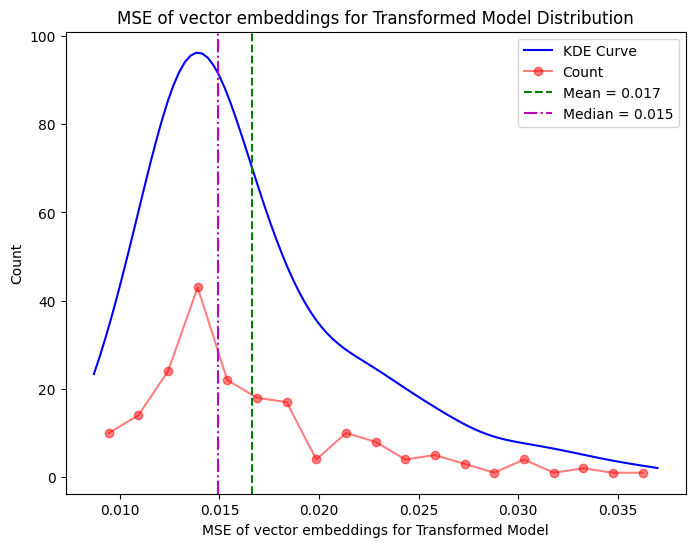

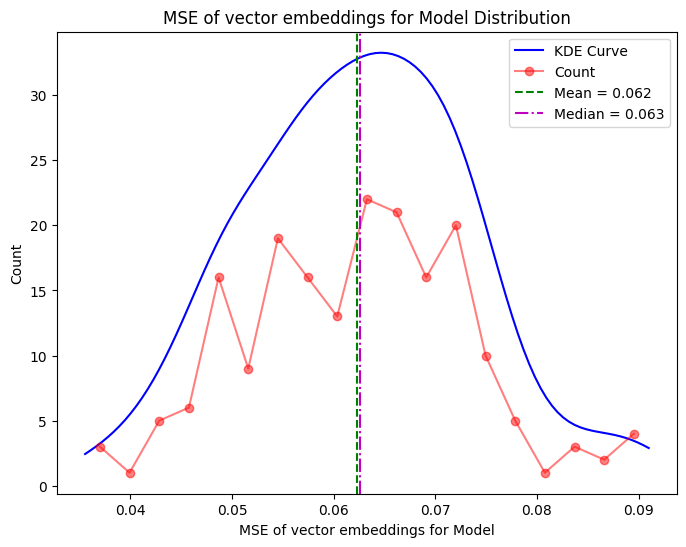

In [10]:
# ------------------------ MSE of embedding across dataset -----------------------------
num = len(input_dataset)
MSE_transformed = []
MSE_original = []
print(f"\nMSE between vector embeddings of Pencorr (A) and Model:")   
for i in range(num):
    difference_squared = (matrixA[:,i] - model_transformed[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
    MSE_transformed.append(mean_squared_difference)
    difference_squared = (matrixA[:,i] - model_vectors[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Original matrix of Index {i}: {mean_squared_difference}")
    MSE_original.append(mean_squared_difference)
    
imgplt.plot_score_distribution(MSE_transformed, "MSE of vector embeddings for Transformed Model")
imgplt.plot_score_distribution(MSE_original, "MSE of vector embeddings for Model")


MSE between vector embeddings of dimension 16 for Pencorr (A) and Model:


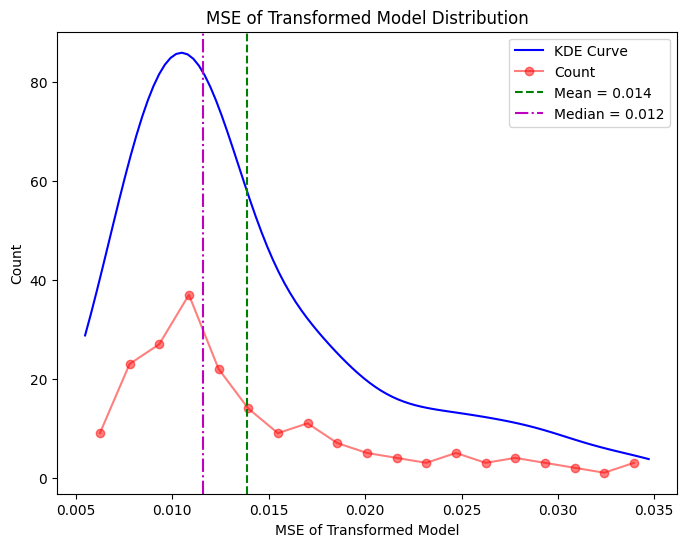

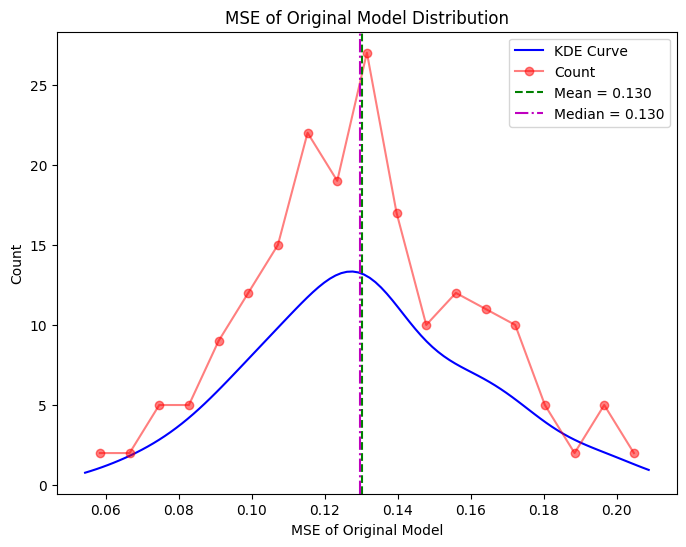


MSE between vector embeddings of dimension 32 for Pencorr (A) and Model:


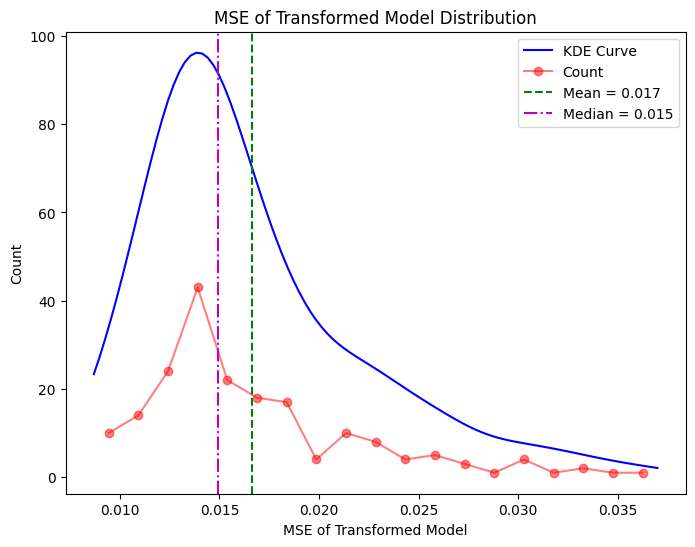

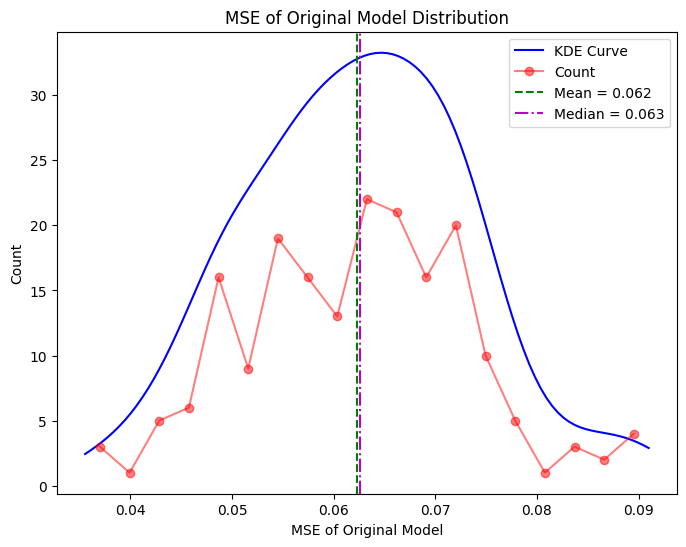


MSE between vector embeddings of dimension 48 for Pencorr (A) and Model:


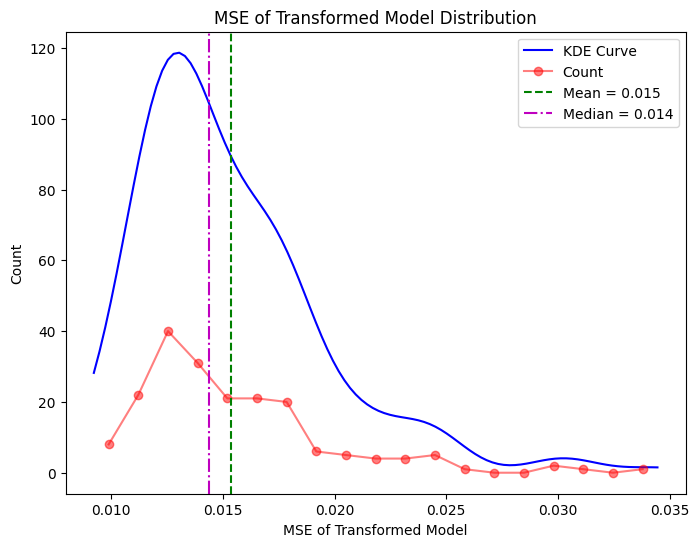

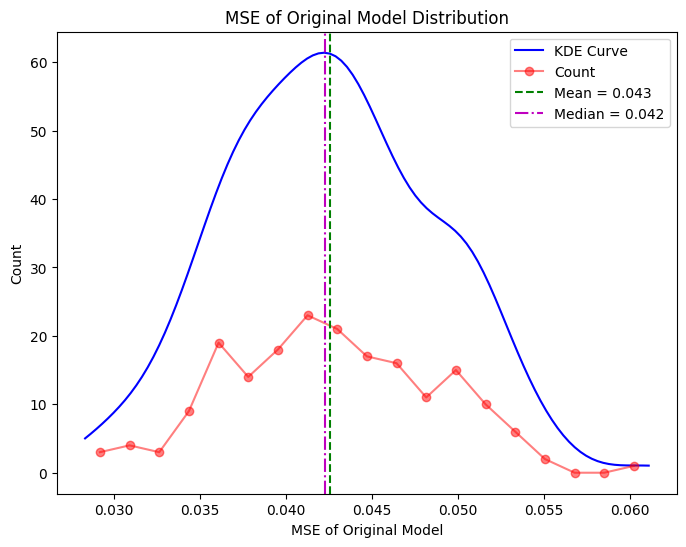

In [11]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
dimensions = [16, 32, 48]
for dim in dimensions:
    
    embeddingType = f"pencorr_{dim}"
    bruteForceEstimator = bfEstimator.BruteForceEstimator(
        imageType=imageType, filters=filters, imageProductType=imageProductType, embeddingType=embeddingType, overwrite=overwrite)
    
    input_dataset = []
    for img in bruteForceEstimator.imageSet:
        img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
        input_dataset.append(img_tensor)
    input_dataset = [tensor.float() for tensor in input_dataset] 
    stacked_tensor = torch.stack(input_dataset)
    input_dataset = stacked_tensor.cpu().numpy()      
    input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
    num = len(input_dataset)
    
    model = models.SimpleCNN(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                                   f"best_model_batch_greyscale_8bin_LPS_circular_{dim}d.pt"),
                                                    map_location=torch.device('cpu')))
    model.eval()
    
    matrixG = bruteForceEstimator.matrixG
    matrixA = bruteForceEstimator.matrixA
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    MSE_transformed = []
    MSE_original = []
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Model:")   
    for i in range(num):
        difference_squared = (matrixA[:,i] - model_transformed[i].detach().cpu().numpy()) ** 2
        mean_squared_difference = np.sum(difference_squared) / difference_squared.size
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)
        difference_squared = (matrixA[:,i] - model_vectors[i].detach().cpu().numpy()) ** 2
        mean_squared_difference = np.sum(difference_squared) / difference_squared.size
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
        
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

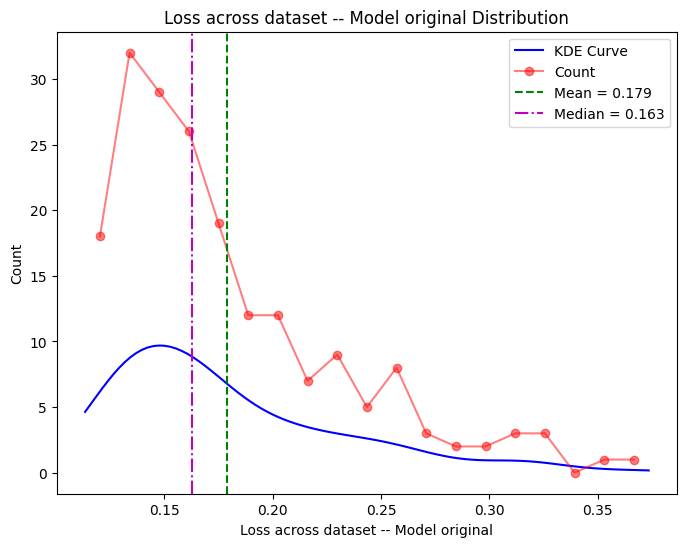

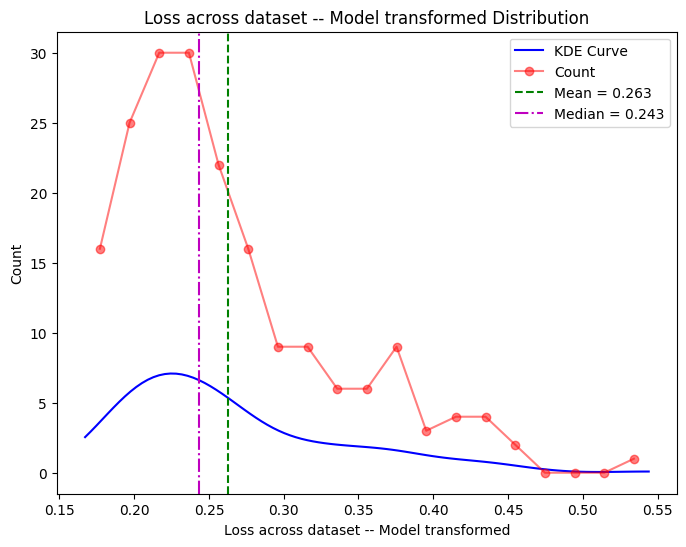

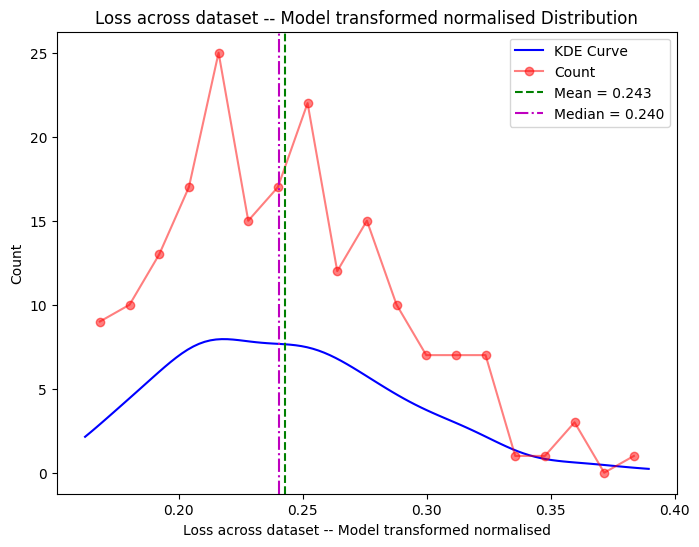

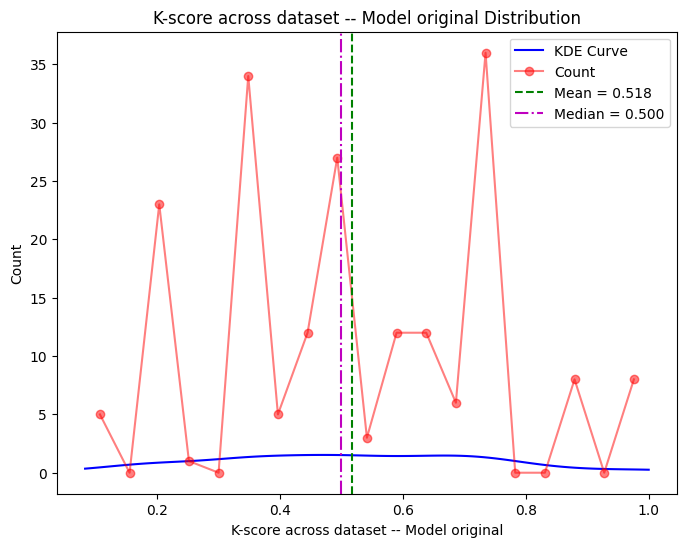

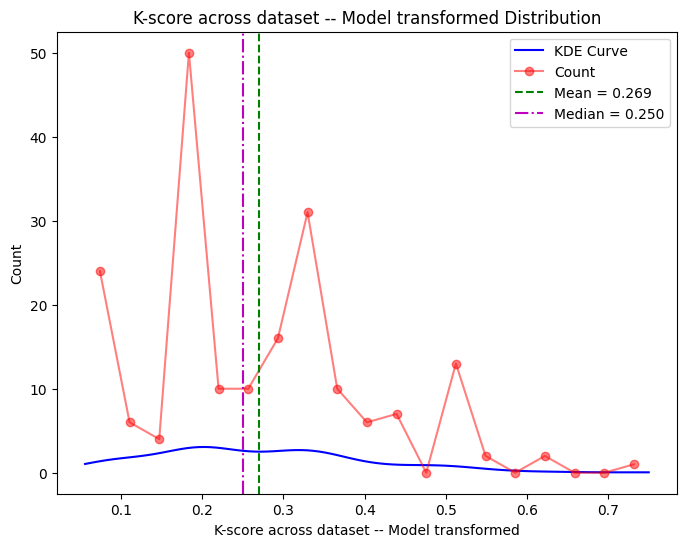

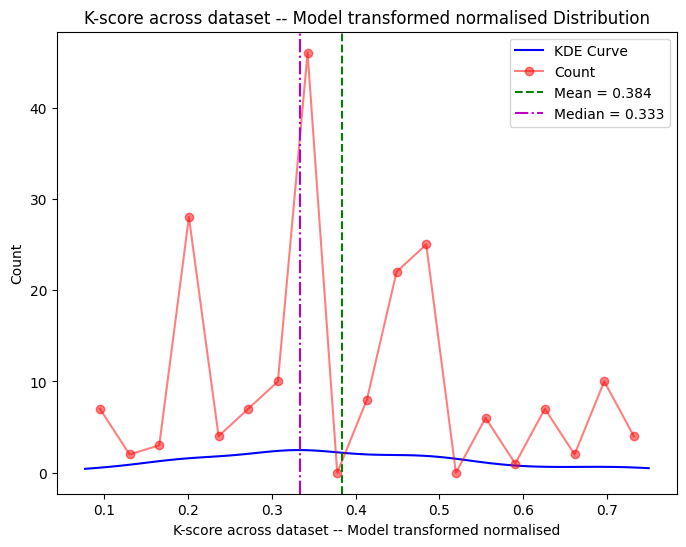

In [24]:
# ------------------------ Loss and Kscores of transformed embedding across dataset -----------------------------
num = len(input_dataset)
loss_transformed_normalised = []
loss_transformed = []
loss_original = []
kscore_transformed_normalised = []
kscore_transformed = []
kscore_original = []

for i in range(num):
        vectorb = imgcalc.get_vectorb_model(i, model, bruteForceEstimator.imageSet)

        input2_original = model_vectors[i]
        input2_transformed = model_transformed[i]
        input2_transformed_normalised =  model_transformed[i]/np.linalg.norm(model_transformed[i].detach().cpu().numpy())
        
        vectorc_original = []
        vectorc_transformed = []
        vectorc_transformed_normalised = []

        loss_value_transformed_normalised = []
        loss_value_transformed = []
        loss_value_original = []
        for j in range(num):
            input1_original = model_vectors[j]
            input1_transformed = model_transformed[j]
            input1_transformed_normalised =  model_transformed[j]/np.linalg.norm(model_transformed[j].detach().cpu().numpy())
            
            dot_product_orignal = torch.sum(input1_original * input2_original, dim=1)
            dot_product_transformed = torch.sum(input1_transformed * input2_transformed, dim=1)
            dot_product_transformed_normalised = torch.sum(input1_transformed_normalised * input2_transformed_normalised, dim=1)
            
            vectorc_original.append(dot_product_orignal.detach().cpu().numpy().item())
            vectorc_transformed.append(dot_product_transformed.detach().cpu().numpy().item())
            vectorc_transformed_normalised.append(dot_product_transformed_normalised.detach().cpu().numpy().item())

            NCC_scaled_value = imgcalc.get_NCC_score(bruteForceEstimator.imageSet[i], bruteForceEstimator.imageSet[j])
            
            loss_value = imgcalc.get_loss_value(dot_product_orignal, NCC_scaled_value) 
            loss_value_original.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed, NCC_scaled_value) 
            loss_value_transformed.append(loss_value)

            loss_value = imgcalc.get_loss_value(dot_product_transformed_normalised, NCC_scaled_value) 
            loss_value_transformed_normalised.append(loss_value)

        average_loss_original = sum(loss_value_original) / len(loss_value_original)
        average_loss_transformed = sum(loss_value_transformed) / len(loss_value_transformed)
        average_loss_transformed_normalised = sum(loss_value_transformed_normalised) / len(loss_value_transformed_normalised)

        loss_original.append(average_loss_original)
        loss_transformed.append(average_loss_transformed)
        loss_transformed_normalised.append(average_loss_transformed_normalised)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_original, k)
        kscore_original.append(kscore)
    
        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed, k)
        kscore_transformed.append(kscore)

        kscore, _, _ = imgcalc.get_kscore_and_sets(vectorb, vectorc_transformed_normalised, k)
        kscore_transformed_normalised.append(kscore)
    
imgplt.plot_score_distribution(loss_original, "Loss across dataset -- Model original")
imgplt.plot_score_distribution(loss_transformed, "Loss across dataset -- Model transformed")
imgplt.plot_score_distribution(loss_transformed_normalised, "Loss across dataset -- Model transformed normalised")
imgplt.plot_score_distribution(kscore_original, "K-score across dataset -- Model original")
imgplt.plot_score_distribution(kscore_transformed, "K-score across dataset -- Model transformed")
imgplt.plot_score_distribution(kscore_transformed_normalised, "K-score across dataset -- Model transformed normalised")